## Importing libraries

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import py21cmfast as p21c

## Cosmological Parameters (Default is used when no input is specified)

In [34]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [35]:
BOX_LEN=301  # Box length
DIM=2*BOX_LEN      # Number of Voxels for hight resolution 
HII_DIM=BOX_LEN  # Number of Voxels for low resolution 

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,
    DIM=DIM,
    HII_DIM=HII_DIM
)

In [2]:
import py21cmfast as p21c
p21c.UserParams?

## Creating initial conditions box

In [36]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Gaussian function

In [37]:
def Gaussian(x, sigma=1, mu=0):
    return (1/sigma/np.sqrt(2*np.pi))*(np.exp(-0.5*(((x-mu)/sigma)**2)))

## Measure the distance of each voxel to the center

In [38]:
def distance_from_coordinate(box_shape):
    index_x = np.arange(-0.5*(box_shape[0]-1), 0.5*(box_shape[0]+1))
    index_y = np.arange(-0.5*(box_shape[1]-1), 0.5*(box_shape[1]+1))
    index_z = np.arange(-0.5*(box_shape[2]-1), 0.5*(box_shape[2]+1))

    x_mesh, y_mesh, z_mesh = np.meshgrid(index_x, index_y, index_z, indexing='ij')

    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [39]:
def random_voxel(box_shape):
    np.random.seed()  # set seed to a randome number    
#     np.random.seed(5) ; np.random.rand(10)
    
    coordinate = [np.random.randint(0, side_length) for side_length in box_shape]
    
    return coordinate

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [40]:
def cube_centered_about_coordinate(coordinate_array, radius, box):
    x_ind1 = coordinate_array[0]-radius  # x-domian
    x_ind2 = coordinate_array[0]+radius+1  # ending index is not inclusive
    y_ind1 = coordinate_array[1]-radius  # y-domain
    y_ind2 = coordinate_array[1]+radius+1
    z_ind1 = coordinate_array[2]-radius  # z-domain
    z_ind2 = coordinate_array[2]+radius+1

    if x_ind1 < 0:  # periodic boundary conditions
        x_inds = np.r_[(x_ind1+box.shape[0]):box.shape[0], 0:x_ind2]
    elif x_ind2 > box.shape[0]:
        x_inds = np.r_[x_ind1:box.shape[0], 0:(x_ind2-box.shape[0])]
    else:
        x_inds = np.r_[x_ind1:x_ind2]

    if y_ind1 < 0:
        y_inds = np.r_[(y_ind1+box.shape[1]):box.shape[1], 0:y_ind2]
    elif y_ind2 > box.shape[1]:
        y_inds = np.r_[y_ind1:box.shape[1], 0:(y_ind2-box.shape[1])]
    else:
        y_inds = np.r_[y_ind1:y_ind2]

    if z_ind1 < 0:
        z_inds = np.r_[(z_ind1+box.shape[2]):box.shape[2], 0:z_ind2]
    elif z_ind2 > box.shape[2]:
        z_inds = np.r_[z_ind1:box.shape[2], 0:(z_ind2-box.shape[2])]
    else:
        z_inds = np.r_[z_ind1:z_ind2]

    indices = np.ix_(x_inds, y_inds, z_inds)
    
    cube = box[indices]
    
    return cube

## Average values of a shperical region in a given box,  with diameter = sides of box, sphere centered on cube's center

In [41]:
def top_hat_sphere_average_value(distance_box, radius, input_box):
    sphere_condition_box =  distance_box <= radius
    inside_sphere_mean = np.mean(input_box[sphere_condition_box])  # slicing shaped array by condition will ravel the array
    return inside_sphere_mean

## Gausssian Averaging

In [42]:
def gaussian_sphere_average_value(distance_box, radius, input_box, shell_num):
    
    mean = []

    shell_radius_edges = np.linspace(0,1,shell_num+1)
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])
    weight = Gaussian(x=shell_center*4)

    for ii in range(shell_num):
        condition = np.logical_and(distance_box <= shell_radius_edges[ii+1]*radius, distance_box > shell_radius_edges[ii]*radius)
        inside_shell_mean = np.mean(input_box[condition])
        mean = np.append(mean, inside_shell_mean)

    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean

## Sphere Blurring Function

In [43]:
def Average_Neutral_Fraction_Distribution(box, radius, iteration, shell_num=1):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    dist_frm_coord_box = distance_from_coordinate([radius*2+1]*3)

    inside_sphere_mean_data = []  # empty list for data collection
    
    for i in range(iteration):
        
        rand_coord = random_voxel(box.shape)
                
        cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
        
        inside_sphere_mean = gaussian_sphere_average_value(dist_frm_coord_box, radius, cube_region_box, shell_num)
        
        inside_sphere_mean_data = np.append(inside_sphere_mean_data, inside_sphere_mean)
        
    return np.array(inside_sphere_mean_data)

## Make the colorbar fit with the plot in the figures

In [44]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label="Neutral Fraction")
    plt.sca(last_axes)
    return cbar

## Histogram Function

In [45]:
def histogram(f1, x_start=0, x_stop=1, bin_num=100):  # a: x start, b: x stop
    bin_edges = np.linspace(x_start, x_stop, bin_num) # 100 bins from 0-1
    hist1, _ = np.histogram(f1, bins=bin_edges)
#     hist2, _ = np.histogram(f2, bins=bin_edges)
#     hist3, _ = np.histogram(f3, bins=bin_edges)

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    fig, axes = plt.subplots(ncols=1, figsize=(8,8))
    axes.plot(bin_centers, hist1)
#     axes[1].plot(bin_centers, hist2)
#     axes[2].plot(bin_centers, hist3)
#     plt.title("Distribution", color='white')
#     plt.xlabel("Neutral Fraction", color='white')
    
    # Set the borders to a given color...
#     for ax in axes:
    axes.tick_params(color='white', labelcolor='white')
    for spine in axes.spines.values():
        spine.set_edgecolor('white')

## Creating Ionize box

In [46]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

## Creating Noise Box

In [47]:
np.random.seed()
noise_box = np.random.rand(BOX_LEN, BOX_LEN, BOX_LEN)

## Blurring the box

In [51]:
%%timeit
Avg_Neu_Frac_Dist = Average_Neutral_Fraction_Distribution(box=ionized, radius=150, iteration=1, shell_num=5)

1.6 s ± 5.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Creating Histogram

# Distribution of average values of a noise box

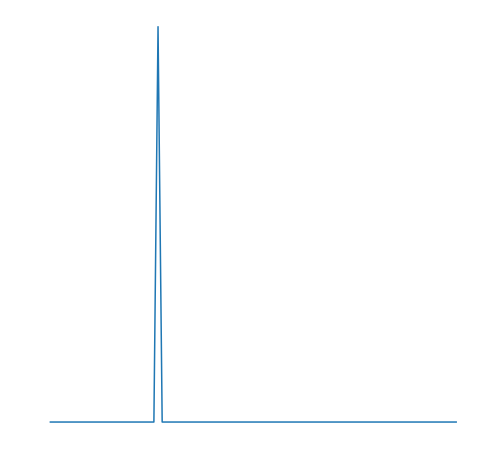

In [49]:
histogram(Avg_Neu_Frac_Dist)

In [50]:
Avg_Neu_Frac_Dist

array([0.27219977])